<a href="https://colab.research.google.com/github/waleedGeorgy/deep-learning/blob/main/Deep_Learning_Research_Paper_Replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We'll try to replicate the research paper "**An Image Is Worth 16X16 Words: Transformers For Image Recognition At Scale**" - [Paper here](https://arxiv.org/abs/2010.11929)

# Setting up

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (1234/1234), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 4056 (delta 1141), reused 1124 (delta 1124), pack-reused 2822
Receiving objects: 100% (4056/4056), 649.94 MiB | 33.13 MiB/s, done.
Resolving deltas: 100% (2386/2386), done.
Updating files: 100% (248/248), done.


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
data_path = download_data(source = 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
                          destination = 'pizza_steak_sushi')

data_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
train_dir = data_path / 'train'
test_dir = data_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Creating datasets and DataLoaders

- As described in the research paper, we'll try to replicate the ViT (vision transformer) architecture and apply it to our own problem.
- To start off, we'll need to resize the images to 224x224, and use a batch size of 4096.
- The former is easy to achieve but the latter may prove too much for the basic hardware provided by Google Colab. So, we'll stick to a batch size of 32.

In [ ]:
# Creating the manual transform
from torchvision import transforms

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [ ]:
# Creating the dataloaders
import os

BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = BATCH_SIZE,
                                                                               num_workers = os.cpu_count())

In [ ]:
class_names, len(train_dataloader), len(test_dataloader)

(['pizza', 'steak', 'sushi'], 8, 3)

# Visualizing an image

In [ ]:
# Getting a single batch from the train dataloader
img_batch, label_batch = next(iter(train_dataloader))
img, label = img_batch[0], label_batch[0]

img.shape, label

(torch.Size([3, 224, 224]), tensor(0))

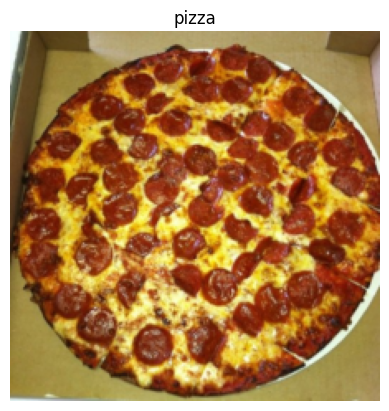

In [ ]:
# Visualizing the img and labeling it
import matplotlib.pyplot as plt

plt.imshow(img.permute(1,2,0))
plt.axis(False)
plt.title(class_names[label]);

# Overview of the ViT

The ViT described in the paper can be broken down into these basic component:
- **INPUTS** - What goes into a layer / block / model? (e.g. batches of image tensors).
- **OUTPUTS** - What goes out of a layer / block / model? (e.g. classification labels & predictions).
- **LAYERS** - Take an input, and manipulate it with a mathmatical equation or function. (self-attention / multi-head attention, LayerNorm, etc...)
- **BLOCKS** - A group of layers.
- **MODEL** - A group of blocks.

## ViT in more detail
The components we'll need in order to build the model described in the research paper can be extracted from three main sources:

### Figure 1
Main model architecture (p. 3)
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true)

**Embeddings** - are numerical representations of real-world objects that ML and AI systems use to understand complex knowledge domains like humans do. As an example, computing algorithms understand that the difference between 2 and 3 is 1, indicating a close relationship between 2 and 3 as compared to 2 and 100. However, real-world data includes more complex relationships. For example, a bird-nest and a lion-den are analogous pairs, while day-night are opposite terms. Embeddings convert real-world objects into complex mathematical representations that capture inherent properties and relationships between real-world data. The entire process is automated, with AI systems self-creating embeddings during training and using them as needed to complete new tasks.

---

### The Four Equations
The mathmatical representations of the layers in ViT (p. 4)
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true)

- **Equations 1:**

The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathrm{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathrm{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

[**What is a Transformer model?**](https://blogs.nvidia.com/blog/what-is-a-transformer-model/)

```
# Equation 1
x_input = [class_token, img_patch_1, img_patch_2, ..., img_patch_N] + [class_token_pos, img_patch_1_pos, img_patch_2_pos, ..., img_patch_N_pos]
```

- **Equation 2 & 3:**

The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded self-attention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

**Layer normalization (LN)** computes the mean and standard deviation across each individual observation (over all channels in case of images) rather than across the batch. This makes it batch-size independent and can therefore be used in models like RNNs or in transformer models.

[**What is self-attention?**](https://h2o.ai/wiki/self-attention/)

[**What is multihead-attention?**](https://www.analyticsvidhya.com/blog/2023/06/understanding-attention-mechanisms-using-multi-head-attention/)

[**Difference between Attention, Self-Attention and Multi-Head Attention?**](https://www.adityaagrawal.net/blog/deep_learning/attention)

```
# Equation 2:
x_output_MSA_block = MHA_layer(LN_layer(x_input)) + x_input

# Equation 3:
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

The output of each block is a combination of the actual output of the block + the raw input of the same block using a residual connection.

**Residual connections** -  are additional links that connect some layers in a neural network to other layers that are not directly adjacent. For example, in a typical convolutional neural network (CNN), each layer receives input from the previous layer and passes output to the next layer. However, with residual connections, some layers can also receive input from or send output to layers that are several steps away. This creates a parallel path for information flow that bypasses some intermediate layers.


They work by adding the output of a previous layer to the input of a later layer. This means that the later layer does not have to learn the entire function that maps the input to the output, but only the residual or difference between them. For example, if the input is x and the output is y, then the layer with a residual connection only has to learn the function f(x) such that y = x + f(x). This makes the learning process easier and more stable, as the layer can simply learn an identity function f(x) = 0 if there is no difference between x and y.

Residual connections are beneficial for several reasons. First, they help alleviate the problem of vanishing or exploding gradients, which occurs when the gradients of the loss function become too small or too large as they propagate back through the network. This can cause the network to stop learning or diverge. Residual connections allow the gradients to flow more directly and smoothly through the network, avoiding these extremes. Second, they help prevent overfitting, which occurs when the network memorizes the training data and fails to generalize to new data. Residual connections introduce some regularization and diversity to the network, making it less prone to overfitting. Third, they help avoid degradation, which occurs when the network performance deteriorates as more layers are added. Residual connections enable the network to preserve or improve its performance by learning incremental features rather than redundant or irrelevant ones.

- **Equation 4:**

Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathrm{z}_0^0=\mathrm{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathrm{z}_L^0\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathrm{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

**BERT** - short for Bidirectional Encoder Representations from Transformers, is a ML model for natural language processing based on the transformer architecture. It helps models understand ambiguous language in text by using surroudning text to establish context.

**MLP** = Multi-layer perceptron, a general term for FNNs with x number of layers.

In our case

**MLP** = one hidden layer at pre-training time.

**MLP** = one linear layer at fine-tuning time.

```
# Equation 4
y = linear_layer(LN_layer(x_output_MLP_block))
```

---

### Table 1
ViT model variants (p. 5)
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true)